# Constructing a Diversified Stock Portfolio using Machine Learning Techniques

## Import Libararies

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
plt.style.use('default')
%matplotlib inline

from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans, Birch, AgglomerativeClustering
import matplotlib.cm as cm
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score,calinski_harabasz_score
from yellowbrick.cluster import SilhouetteVisualizer

import yfinance as yf
import datetime
import time

from sklearn.ensemble import RandomForestClassifier

from arch import arch_model
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

# Part 1: Unsupervised Learning - Clustering of Stocks using Fundamental Metrics

## Data Preprocessing: Loading the Data and Removing Null Values

In [2]:
# Import the excel table into df
# (REQUIRES THE EXCEL FILE PROVIDED IN THE ZIP FOLDER, MAKE SURE THE DIRECTORY IS CHANGED BEFORE RUNNING)
df = pd.read_excel("/Users/mathias/Documents/UoM/YEAR3/THIRD YEAR PROJECT/DATA/FINAL DATA/S&P_500_End_of_Year_2020_Fundamental_FINAL.xlsx")

# Set the index to 'Ticker'
df.set_index('Ticker', inplace = True)

# Pivot to make the fundamental ratios the features and the stocks the rows
df = df.pivot(columns='Feature', values='Value')

# Remove 'feature' label
df.columns.name = None

# Drop stocks with missing values (78 stocks removed)
df = df.dropna()

# Standardise the data 
standard_scaler = StandardScaler()
X_standardised = standard_scaler.fit_transform(df)

In [3]:
# Create a list that stores all the stocks that have been clustered
list_of_stocks = df.index.values.tolist() 

In [4]:
list_of_stocks

['A',
 'AAPL',
 'ABC',
 'ABT',
 'ADBE',
 'ADI',
 'ADM',
 'ADP',
 'ADSK',
 'AEE',
 'AEP',
 'AES',
 'AKAM',
 'AMAT',
 'AMD',
 'AMGN',
 'AMZN',
 'ANTM',
 'APA',
 'APD',
 'APH',
 'AVY',
 'BA',
 'BAX',
 'BBWI',
 'BBY',
 'BDX',
 'BF-B',
 'BIIB',
 'BKNG',
 'BLL',
 'BMY',
 'BSX',
 'CAG',
 'CAH',
 'CAT',
 'CCL',
 'CF',
 'CHRW',
 'CI',
 'CL',
 'CLX',
 'CMI',
 'CMS',
 'CNP',
 'COP',
 'COST',
 'CPB',
 'CRM',
 'CSCO',
 'CTAS',
 'CTRA',
 'CTSH',
 'CTXS',
 'CVS',
 'CVX',
 'D',
 'DE',
 'DGX',
 'DHR',
 'DIS',
 'DOV',
 'DRI',
 'DTE',
 'DUK',
 'DVA',
 'DVN',
 'EA',
 'EBAY',
 'ECL',
 'ED',
 'EFX',
 'EIX',
 'EL',
 'EMN',
 'EMR',
 'EOG',
 'ES',
 'ETN',
 'ETR',
 'EXC',
 'EXPD',
 'EXPE',
 'F',
 'FAST',
 'FCX',
 'FDX',
 'FE',
 'FIS',
 'FISV',
 'GD',
 'GE',
 'GILD',
 'GIS',
 'GLW',
 'GPC',
 'GWW',
 'HAL',
 'HAS',
 'HD',
 'HES',
 'HPQ',
 'HRL',
 'HSY',
 'HUM',
 'IBM',
 'IFF',
 'INTC',
 'INTU',
 'IP',
 'IPG',
 'IRM',
 'ISRG',
 'ITW',
 'J',
 'JNJ',
 'JNPR',
 'K',
 'KLAC',
 'KMB',
 'KO',
 'KR',
 'LDOS',
 'LEN',
 'L

## Data Preprocessing: PCA (Dimensionality Reduction)

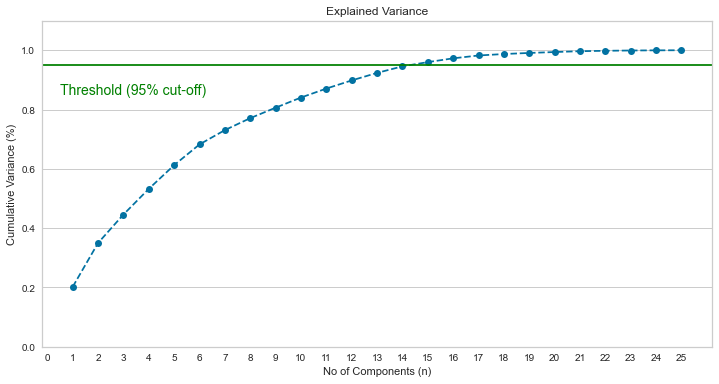

In [5]:
# Apply PCA to reduce the number of dimensions (as there are currently 25 features or financial fundamental metrics)
# Plot explained variance graph to determine number of principle components
pca = PCA().fit(X_standardised)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 26, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('No of Components (n)')
plt.xticks(np.arange(0, 26, step=1))
plt.ylabel('Cumulative Variance (%)')
plt.title('Explained Variance')

plt.axhline(y=0.95, color='green', linestyle='-')
plt.text(0.5, 0.85, 'Threshold (95% cut-off)', color = 'green', fontsize=14)

ax.grid(axis='x')
plt.show()

In [6]:
# Fit PCA to standardised data using 14 components
X = PCA(n_components=14).fit(X_standardised).transform(X_standardised)

Look at the 'Clustering Algorithms - EVALUATION' jupyter notebook to see how it was decided that K-Means would be used to cluster the stocks (a comparison of K-Means, BIRCH, Ward, Average and Complete Linkage was carried out)

K-Means is determined as the best clustering algorithm and 14 clusters is found to be the optimal for this scenario.

In [7]:
no_of_kmeans_clusters = 14

# Implementing k-means With Optimal Clusters
kmeans = KMeans(n_clusters=no_of_kmeans_clusters, random_state=0)
kmeans.fit(X)
df['kmeans_labels'] = kmeans.labels_

In [8]:
# K-Means - Count the Number of Stocks in Each Cluster
k_means_stocks_in_cluster = []
curr_no_of_stocks = 0
print("K-Means: Number of Stocks in Each Cluster")
print()
for i in range(0, no_of_kmeans_clusters):
    curr_no_of_stocks = len(df.query('kmeans_labels == @i').index)
    print("Cluster " + str(i+1) + ": " + str(curr_no_of_stocks))

K-Means: Number of Stocks in Each Cluster

Cluster 1: 43
Cluster 2: 67
Cluster 3: 2
Cluster 4: 3
Cluster 5: 1
Cluster 6: 8
Cluster 7: 12
Cluster 8: 5
Cluster 9: 58
Cluster 10: 2
Cluster 11: 9
Cluster 12: 4
Cluster 13: 5
Cluster 14: 5


Clusters that have 5 or less stocks are not appropriate to select stocks from so these will be merged into a new single cluster.

In [9]:
# Extract stock tickers from the clusters that have more than 5 stocks
kmeans_cluster_1 = df.query('kmeans_labels == 0').index.values.tolist()  
kmeans_cluster_2 = df.query('kmeans_labels == 1').index.values.tolist()  
kmeans_cluster_3 = df.query('kmeans_labels == 5').index.values.tolist() 
kmeans_cluster_4 = df.query('kmeans_labels == 6').index.values.tolist()
kmeans_cluster_5 = df.query('kmeans_labels == 8').index.values.tolist()
kmeans_cluster_6 = df.query('kmeans_labels == 10').index.values.tolist()

In [10]:
# Extract stock tickers from the clusters that have less (or equal to) than 5 stocks
clusters_with_five_or_less = []
curr_no_of_stocks = 0
kmeans_cluster_7 = []

# Adds all the tickers with less than 5 stocks to cluster 7
for i in range(0, no_of_kmeans_clusters):
    curr_no_of_stocks = len(df.query('kmeans_labels == @i').index)
    curr_cluster = df.query('kmeans_labels == @i').index.values.tolist()  
    if curr_no_of_stocks <= 5:
        kmeans_cluster_7 += curr_cluster

In [11]:
# Store the tickers in a dictionary
k_means_initial_clusters = {}

k_means_initial_clusters['1'] = kmeans_cluster_1
k_means_initial_clusters['2'] = kmeans_cluster_2
k_means_initial_clusters['3'] = kmeans_cluster_3
k_means_initial_clusters['4'] = kmeans_cluster_4
k_means_initial_clusters['5'] = kmeans_cluster_5
k_means_initial_clusters['6'] = kmeans_cluster_6
k_means_initial_clusters['7'] = kmeans_cluster_7

The final number of clusters is 7 and here are the number of stocks in each cluster.

In [12]:
print("No of Stocks in Each Cluster")
print()

for i in range(0, 7):
    # Convert to cluster number
    cluster_no = str(i + 1)
    # Output number of stocks in cluster
    print("Cluster " + cluster_no + ": " + str(len(k_means_initial_clusters[cluster_no])))

No of Stocks in Each Cluster

Cluster 1: 43
Cluster 2: 67
Cluster 3: 8
Cluster 4: 12
Cluster 5: 58
Cluster 6: 9
Cluster 7: 27


The next step is calculating the VaR (Value at Risk) for each of these stocks.

# Part 2: Calculating VaR (Value at Risk)

In [13]:
# Define dates for training windows (element 0 is window 1, element 1 is window 2, etc..)
w_start_train = ["2011-1-3", "2011-2-2", "2011-3-4", "2011-4-4", "2011-5-4", "2011-6-3", "2011-7-5", "2011-8-3", "2011-9-1", "2011-10-3", "2011-11-1", "2011-12-2"]
w_end_train = ["2021-1-4", "2021-2-3", "2021-3-5", "2021-4-6", "2021-5-5", "2021-6-4", "2021-7-6", "2021-8-4", "2021-9-2", "2021-10-4", "2021-11-2", "2021-12-2"]


In [14]:
# Download the Closing Price for all the stocks from the start to the end train period
close_df = pd.DataFrame()

for ticker in list_of_stocks:
    close_df[ticker] = yf.download(ticker, start=w_start_train[0], end="2022-1-3")['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

/var/folders/s4/j07kbjwj0275mp498nkb8jx80000gn/T/ipykernel_51843/1084417177.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  close_df[ticker] = yf.download(ticker, start=w_start_train[0], end="2022-1-3")['Close']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [15]:
close_df

,A,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WM,WMB,WMT,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-03,29.957083,11.770357,34.320000,22.944036,31.290001,37.950001,30.400000,41.308167,39.270000,28.250000,...,36.820000,20.151745,54.560001,19.760000,108.989998,23.559999,74.550003,35.099998,35.291157,53.368931
2011-01-04,29.678112,11.831786,33.939999,23.159946,31.510000,37.520000,30.379999,41.158913,38.529999,28.459999,...,36.599998,20.005009,54.770000,19.549999,112.389999,23.660000,74.900002,34.709999,34.751976,52.660194
2011-01-05,29.613733,11.928571,34.459999,23.159946,32.220001,37.599998,30.520000,41.817383,41.240002,28.400000,...,36.580002,20.037617,54.410000,20.160000,113.839996,23.520000,74.699997,35.040001,34.917328,52.699028
2011-01-06,29.670959,11.918929,34.860001,23.111965,32.270000,37.810001,31.690001,42.142231,41.259998,28.290001,...,36.410000,19.996857,53.959999,20.020000,114.669998,23.500000,75.180000,34.840000,35.161755,51.067963
2011-01-07,29.771103,12.004286,34.930000,23.207926,32.040001,37.590000,31.950001,42.238808,40.759998,28.290001,...,36.209999,20.314783,54.080002,20.570000,118.730003,23.709999,75.589996,34.700001,35.600288,51.058250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,158.740005,180.330002,131.899994,141.460007,577.679993,175.470001,66.070000,246.289993,284.299988,87.550003,...,163.789993,26.260000,140.759995,39.660000,87.580002,66.820000,61.889999,55.950001,138.009995,124.087379
2021-12-28,159.179993,179.289993,132.360001,140.470001,569.359985,174.380005,66.930000,246.070007,282.769989,88.419998,...,165.139999,26.160000,142.779999,39.860001,86.459999,67.620003,61.689999,56.029999,137.979996,124.475731
2021-12-29,160.649994,179.380005,133.339996,141.190002,569.289978,175.520004,67.010002,248.009995,282.570007,88.910004,...,166.380005,26.040001,142.710007,40.680000,84.980003,67.959999,61.150002,56.650002,138.660004,124.495148


In [16]:
# Define function to calculate 21 day returns and sort them in ascending order
def calculate_sorted_21_day_returns(start_date, end_date):
    curr_window_sorted_returns_df = pd.DataFrame()
    
    # Get the 21 day returns for the specified window
    curr_window_sorted_returns_df = close_df[start_date:end_date].pct_change(21)
    
    # Drop first 20 rows as they do not have enough data for 21 day returns
    curr_window_sorted_returns_df = curr_window_sorted_returns_df.dropna()
    
    # Sort the returns in ascending order
    curr_window_sorted_returns_df = pd.DataFrame(np.sort(curr_window_sorted_returns_df.values, axis=0), index=curr_window_sorted_returns_df.index, columns=curr_window_sorted_returns_df.columns)
    
    return curr_window_sorted_returns_df

In [17]:
# Create a dictionary which will store dataframes of sorted returns of each training window
sorted_returns = {}

# Store the dataframes of sorted returns in a dictionary
for i in range(0, 12):
    # Define key for dictionary as "w(x)" where x is the window number
    window_no = "w" + str(i + 1)
    # Store dataframe of sorted returns for current window in the dictionary
    sorted_returns[window_no] = calculate_sorted_21_day_returns(w_start_train[i], w_end_train[i])
    

In [18]:
def calculate_VaR(window_number, confidence_level, sorted_returns_dict):
    
    # Quantile value
    q = 0
    
    # Assigns quantile value based on confidence level
    if confidence_level == 90:
        q = 0.1
    elif confidence_level == 95:
        q = 0.05
    elif confidence_level == 99:
        q = 0.01
        
    # Defines a dictionary that will store the key value pairs of VaR values for the current window
    curr_window_dict = {}
    
    # Define key for dictionary as "w(x)" where x is the window number
    window_no = "w" + str(window_number)
    
    # Calculate VaR for each stock and make the VaR positive as this is the convention
    for ticker in list_of_stocks:
        curr_window_dict[ticker] = abs(sorted_returns_dict[window_no][ticker].quantile(q))
            
    return curr_window_dict
    

In [19]:
# Create the nested dictionaries that will store the VaR_90, 95, 99
VaR_90 = {}
VaR_95 = {}
VaR_99 = {}

# Calculate value at risk for each of the windows, these will be used in the rebalancing

# Calculate VaR_90
for i in range(1, 13):
    # Define key for dictionary as "w(x)" where x is the window number
    window_no = "w" + str(i)
    VaR_90[window_no] = calculate_VaR(i, 90, sorted_returns)
    

# Calculate VaR_95
for i in range(1, 13):
    window_no = "w" + str(i)
    VaR_95[window_no] = calculate_VaR(i, 95, sorted_returns)
    

# Calculate VaR_99
for i in range(1, 13):
    window_no = "w" + str(i)
    VaR_99[window_no] = calculate_VaR(i, 99, sorted_returns)


## Eliminate 50% of stocks based on VaR

Remove 50% stocks from each cluster with the highest VaR so the riskiest stocks are removed. If the number of stocks in a cluster is odd, then keep that extra stock.

A new set of stocks for each cluster are dervied for each rebalancing window.

We are going to use VaR_95.

In [20]:
#Removes the 50% of stocks in each cluster with the highest risk
def filter_high_risk_stocks(window_number, initial_stock_clusters, VaR_dict):
    # Defines a dictionary that will store the key value pairs (Cluster No: Ticker) values for the current window
    curr_window_dict = {}

    # Define key for dictionary as "w(x)" where x is the window number
    window_no = "w" + str(window_number)
    
    # Loops through each cluster
    for i in range(1, 8):
        
        # Stores the the VaR values of the current cluster being looped through in a list
        curr_cluster_VaR = []
        
        # Convert cluster number to string to access key
        cluster_no = str(i)
        
        # Loop through each ticker in current cluster append its VaR value to the list
        for ticker in initial_stock_clusters[cluster_no]:
            curr_cluster_VaR.append(VaR_dict[window_no][ticker])
        
        # Store VaR values and its associated tickers in a Series
        sorted_VaR = pd.Series(curr_cluster_VaR, index=initial_stock_clusters[cluster_no])
        
        # Get half the size of the cluster and round up if odd
        half_size = math.ceil(len(initial_stock_clusters[cluster_no])/2)
        
        # Sort series in ascending order
        sorted_VaR = sorted_VaR.sort_values()
        
        # Get the new set of tickers for the cluster taking the first half of the stocks which aren't risky
        new_cluster_tickers = sorted_VaR[:half_size].index.tolist()
        
        # Store new filtered cluster with its associated cluster as the key
        curr_window_dict[cluster_no] = new_cluster_tickers
        
    return curr_window_dict

In [21]:
# Nested dictionary - first key is the window number, inner key is the cluster number
k_means_clusters = {}

# Each window (1-12) may have a different set of stocks in the clusters depending on the VaR
for i in range(1, 13):
    
    # Define key for dictionary as "w(x)" where x is the window number
    window_no = "w" + str(i)
    
    # Filter the initial clusters to remove the riskiest stocks
    k_means_clusters[window_no] = filter_high_risk_stocks(i, k_means_initial_clusters, VaR_95)


Now we have filtered the stocks for each window we will predict the direction that each of these stocks will move in 21 trading days.

# Part 3: Supervised Learning - Stock Direction Prediction  

Here we have a binary classification problem, where the aim is to correctly predict the direction of a stock after 21 trading days.

After comparing 5 Classification Models (namely Linear Regression, K-Nearest Neighbour, Support Vector Machine, Decision Trees and Random Forest), it was concluded that Random Forest was the best model for predicting the stock direction. Please see the 'Classification Models - EVALUATION' jupyter notebook for more on this.

The following Technical Indicators will be used as features:
- 14-DAY RSI (Relative Strength Index)
- Stochastic Oscillator (%K)
- Williams (%R)
- MACD (Moving Average Convergence Divergence)
- PROC (Price Rate of Change)

In [22]:
# Store the 'Close', 'Low', 'High', 'Open', 'Volume' for all the stocks
stock_data = {}

# Extract data, apply exponential smoothing to it and calculate daily changes - TAKES APPROX 6 MINS TO RUN
for ticker in list_of_stocks:
    stock_data[ticker] = yf.download(ticker, start=w_start_train[0], end="2022-1-3")
    stock_data[ticker] = stock_data[ticker].reset_index(level=0)
    
    # Apply exponential smoothing to each stock, use 21 days (periods) as the predictions will be 21 day predictions
    smoothed_values = stock_data[ticker][['Close','Low','High','Open','Volume']].transform(lambda x: x.ewm(span = 21).mean())
    
    # Concatenate the smoothed values to the date column to get a new dataframe with smoothed values
    stock_data[ticker] = pd.concat([stock_data[ticker][['Date']], smoothed_values], axis=1, sort=False)
    
    # Compute the daily change in price
    stock_data[ticker]['Daily Change'] = stock_data[ticker]['Close'].diff()
    

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [23]:
# -----------------------------------------------------------------
# FUNCTION TO CALCULATE THE 14-DAY RSI (RELATIVE STRENGTH INDEX) 
# -----------------------------------------------------------------

def rsi_14_day(stock_data_df):
    
    for ticker in list_of_stocks:
        
        # Duplicate the Daily Change column and assign the copy to two dataframes which will hold the positive and negative daily changes
        positive_day_change, negative_day_change = stock_data_df[ticker][['Daily Change']].copy(), stock_data_df[ticker][['Daily Change']].copy()
        
        # On positive days, if daily change <  0 then assign a value of 0.
        positive_day_change.loc['Daily Change'] = positive_day_change.loc[(positive_day_change['Daily Change'] < 0), 'Daily Change'] = 0
        
        # On negative days, if daily change >  0 then assign a value of 0.
        negative_day_change.loc['Daily Change'] = negative_day_change.loc[(negative_day_change['Daily Change'] > 0), 'Daily Change'] = 0
        
        # When calculating RSI, all daily changes have to be non-negative
        negative_day_change['Daily Change'] = negative_day_change['Daily Change'].abs()
        
        # Compute the 14 Day Exponential Weighted Moving Average
        positive_ewma = positive_day_change['Daily Change'].transform(lambda x: x.ewm(span = 14).mean())
        negative_ewma = negative_day_change['Daily Change'].transform(lambda x: x.ewm(span = 14).mean())
        
        # Compute the RS (relative strength)
        rs = positive_ewma / negative_ewma
        
        # Calculate the RSI (Relative Strength Index)
        rsi = 100.0 - (100.0 / (1.0 + rs))
        
        # Append new positive and negative day columns to the df
        stock_data_df[ticker]['positive_days'] = positive_day_change['Daily Change']
        stock_data_df[ticker]['negative_days'] = negative_day_change['Daily Change']
        
        # Append RSI column to the dataframe
        stock_data_df[ticker]['RSI'] = rsi
        
    return stock_data_df


In [24]:
# --------------------------------------------------------------------------
# FUNCTION TO CALCULATE THE STOCHASTIC OSCILLATOR (%K) WITH A 14 DAY PERIOD
# --------------------------------------------------------------------------

def stochastic_oscillator(stock_data_df):
    
    for ticker in list_of_stocks:
        
        # Duplicate the Low and High columns and assign them to two dataframes 
        high_14_day, low_14_day = stock_data_df[ticker][['High']].copy(), stock_data_df[ticker][['Low']].copy()
        
        # Get the max and min of each of the 14 day periods
        high_14_day = high_14_day['High'].transform(lambda x: x.rolling(window = 14).max())
        low_14_day = low_14_day['Low'].transform(lambda x: x.rolling(window = 14).min())
        
        # Compute %K
        stch_osc_pct_k = 100 * ((stock_data_df[ticker]['Close'] - low_14_day) / (high_14_day - low_14_day))
        
        # Append High and Low columns to the df
        stock_data_df[ticker]['high_14_day'] = high_14_day
        stock_data_df[ticker]['low_14_day'] = low_14_day
        
        # Append %K column to the dataframe
        stock_data_df[ticker]['stch_osc_pct_k'] = stch_osc_pct_k
        
    return stock_data_df

In [25]:
# -----------------------------------------------------------------
# FUNCTION TO COMPUTE WILLIAMS %R
# -----------------------------------------------------------------

def williams_r(stock_data_df):
    
    for ticker in list_of_stocks:
        
        # Duplicate the Low and High columns and assign them to two dataframes 
        high_14_day, low_14_day = stock_data_df[ticker][['High']].copy(), stock_data_df[ticker][['Low']].copy()
        
        # Get the max and min of each of the 14 day periods
        high_14_day = high_14_day['High'].transform(lambda x: x.rolling(window = 14).max())
        low_14_day = low_14_day['Low'].transform(lambda x: x.rolling(window = 14).min())
        
        # Calculate William %R indicator.
        williams_pct_r = ((high_14_day - stock_data_df[ticker]['Close']) / (high_14_day - low_14_day)) * - 100
        
        # Append Williams %R to the dataframe
        stock_data_df[ticker]['williams_pct_r'] = williams_pct_r
        
    return stock_data_df

In [26]:
# -----------------------------------------------------------------
# FUNCTION TO COMPUTE MACD (Moving Average Covergence Divergence)
# -----------------------------------------------------------------

def macd(stock_data_df):
    
    for ticker in list_of_stocks:
        
        # Calculate 26 day ema
        ema_26 = stock_data_df[ticker]['Close'].transform(lambda x: x.ewm(span = 26).mean())
        
        # Calculate 12 day ema
        ema_12 = stock_data_df[ticker]['Close'].transform(lambda x: x.ewm(span = 12).mean())
        
        # Compute MACD
        macd = ema_12 - ema_26
        
        # Apply 9 day ema to MACD value to get the signal, which is used to indicate if the price is going up or down
        signal = macd.ewm(span = 9).mean()
        
        # Append MACD and signal to dataframe
        stock_data_df[ticker]['MACD'] = macd
        stock_data_df[ticker]['signal'] = signal
    
    return stock_data_df

In [27]:
# -----------------------------------------------------------------
# FUNCTION TO COMPUTE PROC (Price Rate of Change)
# -----------------------------------------------------------------

def proc(stock_data_df):
    
    for ticker in list_of_stocks:
        
        # Compute 21 day PROC (Price Rate of Change)
        stock_data_df[ticker]['price_rate_of_change'] = stock_data_df[ticker]['Close'].transform(lambda x: x.pct_change(periods = 21))
    
    return stock_data_df

In [28]:
# ----------------------------------------------------------------------------------------------------------------
# COMPUTE TARGET VARIABLE VALUES (target = 1, if stock price or is the same goes up after 21 days, otherwise is 0)
# ----------------------------------------------------------------------------------------------------------------

def compute_target_values(stock_data_df):
    
    for ticker in list_of_stocks:
        
        # Extract the 'Close' column from the dataframe.
        target_column = stock_data_df[ticker]['Close']
        
        # Determine the direction of stock price after 21 days for each row (+1 if positive, and 0 if negative)
        target_column = target_column.transform(lambda x: x <= x.shift(-21))
        
        # Convert boolean values and create 'Target' column and append to the dataframe
        stock_data_df[ticker]['Target'] = target_column * 1
        
        # Drop rows with null values
        stock_data_df[ticker] = stock_data_df[ticker].dropna()
    
    return stock_data_df

In [29]:
# Compute the 14-Day RSI (Relative Strength Index) 
stock_data = rsi_14_day(stock_data)
    
# Compute the stochastic oscillator (%K) with a 14 day period
stock_data = stochastic_oscillator(stock_data)
    
# Compute Williams %R
stock_data = williams_r(stock_data)
    
# Compute MACD (Moving Average Convergence Divergence)
stock_data = macd(stock_data)
    
# Compute PROC (Price Rate of Change)
stock_data = proc(stock_data)
    
# Compute target values
stock_data = compute_target_values(stock_data)
  

In [235]:
# Define dates for training windows (element 0 is window 1, element 1 is window 2, etc..)
start_train = ["2011-1-3", "2011-2-2", "2011-3-4", "2011-4-4", "2011-5-4", "2011-6-3", "2011-7-5", "2011-8-3", "2011-9-1", "2011-10-3", "2011-11-1", "2011-12-2"]

# Training has to end 21 days before predict date, as these days will not have 21 days of data to train on
end_train_classif = ["2020-12-2", "2021-1-4", "2021-2-3", "2021-3-5", "2021-4-6", "2021-5-5", "2021-6-4", "2021-7-6", "2021-8-4", "2021-9-2", "2021-10-4", "2021-11-2"]

# A prediction will be made on these dates for the stock direction after 21 days
predict_date = ["2021-1-4", "2021-2-3", "2021-3-5", "2021-4-6", "2021-5-5", "2021-6-4", "2021-7-6", "2021-8-4", "2021-9-2", "2021-10-4", "2021-11-2", "2021-12-2"]

# Create random forest classifier object
rf = RandomForestClassifier(criterion='gini', max_depth = 50, n_estimators=100, random_state=42)

In [236]:
def predict_direction(window_number):
    
    # Define dictionary for predictions
    predictions = {}
    
    # Define key for dictionary as "w(x)" where x is the window number
    window_no = "w" + str(window_number)
    
    # Loop through each stock in each cluster for the current window 
    for cluster_no, cluster in k_means_clusters[window_no].items():
        for ticker in cluster:
            
            # Mask to make sure the data from the correct window is being selected
            mask = (stock_data[ticker]['Date'] >= start_train[window_number-1]) & (stock_data[ticker]['Date'] <= end_train_classif[window_number-1])
            
            # Extract stock data from selected window
            curr_stock_df = stock_data[ticker].loc[mask]
            
            # Extract the features and target values from our X & y columns.
            X = curr_stock_df[['RSI','stch_osc_pct_k','williams_pct_r','price_rate_of_change','MACD']]
            y = curr_stock_df['Target']
            
            # Preprocess training data
            X = standard_scaler.fit_transform(X)
            
            # Fit random forest to the data
            rf.fit(X, y)
            
            # Extract features from the date 21 trading days before the forecast date
            curr_stock_predict_df = stock_data[ticker].loc[stock_data[ticker]['Date'] == predict_date[window_number-1]]
            curr_stock_X = curr_stock_predict_df[['RSI','stch_osc_pct_k','williams_pct_r','price_rate_of_change','MACD']]
            
            # Preprocess test data
            curr_stock_X = standard_scaler.transform(curr_stock_X)
            
            # Use model to make prediction
            curr_stock_pred = rf.predict(curr_stock_X)
            
            # If value is 0 convert this to -1 (so for the stock direction up is 1 and down is -1)
            if curr_stock_pred[0] == 0:
                curr_stock_pred[0] = -1
            
            # Assign prediction value to dictionary
            predictions[ticker] = curr_stock_pred[0]
    
    return predictions

In [237]:
# Store direction predictions for each window
direction_predictions = {}

# Loop through each window
for i in range(1, 13):
    
    # Define key for dictionary as "w(x)" where x is the window number
    window_no = "w" + str(i)
    
    # Assign predictions for each window to dictionary
    direction_predictions[window_no] = predict_direction(i)

In [238]:
direction_predictions['w1']

{'KO': -1,
 'DHR': 1,
 'SYK': 1,
 'CTAS': 1,
 'PAYX': -1,
 'HSY': 1,
 'TMO': 1,
 'BF-B': 1,
 'ITW': -1,
 'ABT': 1,
 'MDT': 1,
 'BAX': 1,
 'LLY': 1,
 'NKE': 1,
 'AMGN': 1,
 'MMM': 1,
 'ADI': 1,
 'ORCL': -1,
 'A': 1,
 'SNA': -1,
 'STZ': 1,
 'WAT': -1,
 'ECL': -1,
 'HRL': 1,
 'BLL': -1,
 'SYY': -1,
 'NOC': 1,
 'GD': 1,
 'DIS': 1,
 'SBUX': -1,
 'PPG': 1,
 'UPS': 1,
 'LH': -1,
 'GPC': 1,
 'VFC': 1,
 'RTX': 1,
 'EXPD': 1,
 'AVY': 1,
 'EMR': -1,
 'IFF': -1,
 'TAP': 1,
 'ABC': -1,
 'CHRW': -1,
 'XRAY': -1,
 'DOV': -1,
 'MAR': -1,
 'LHX': -1,
 'TSN': -1,
 'ANTM': 1,
 'PCAR': -1,
 'TGT': 1,
 'GWW': -1,
 'ADM': 1,
 'CVS': -1,
 'ETN': 1,
 'BMY': 1,
 'CCL': -1,
 'OXY': -1,
 'SLB': 1,
 'HES': 1,
 'PG': 1,
 'PEP': -1,
 'JNJ': 1,
 'VZ': -1,
 'T': -1,
 'PFE': -1,
 'NEE': 1,
 'RSG': 1,
 'MCD': 1,
 'FISV': -1,
 'CLX': 1,
 'XEL': -1,
 'WM': 1,
 'MKC': 1,
 'CMS': 1,
 'DTE': 1,
 'KMB': 1,
 'WEC': 1,
 'SRE': 1,
 'FIS': 1,
 'AEE': 1,
 'GIS': 1,
 'MDLZ': 1,
 'ES': 1,
 'D': -1,
 'SO': -1,
 'ROP': 1,
 'PEG': 1,


## Part 4: GARCH - Calculating Magnitude of Predicted Returns

Here we will calculate the magnitude of predicted returns. The GARCH(1,1) model is fitted to our daily returns data for each stock and we assume a skew-t distribution. 

In [239]:
# Define dates for training windows (element 0 is window 1, element 1 is window 2, etc..)
start_train = ["2011-1-3", "2011-2-2", "2011-3-4", "2011-4-4", "2011-5-4", "2011-6-3", "2011-7-5", "2011-8-3", "2011-9-1", "2011-10-3", "2011-11-1", "2011-12-2"]
end_train = ["2021-1-4", "2021-2-3", "2021-3-5", "2021-4-6", "2021-5-5", "2021-6-4", "2021-7-6", "2021-8-4", "2021-9-2", "2021-10-4", "2021-11-2", "2021-12-2"]


In [240]:
# Store all the stock returns in a dictionary
returns_df = {}

# Calculate daily returns for all stocks
for ticker in list_of_stocks:
    returns_df[ticker] = yf.download(ticker, start=start_train[0], end="2021-12-3")
    returns_df[ticker]['Return'] = 100 * (returns_df[ticker]['Close'].pct_change())
    returns_df[ticker] = returns_df[ticker].dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [241]:
def compute_predicted_returns(window_number):
    
    predicted_volatility = {}
    
    # Define key for dictionary as "w(x)" where x is the window number
    window_no = "w" + str(window_number)
    
    # Loop through each stock in each cluster for the current window 
    for cluster_no, cluster in k_means_clusters[window_no].items():
        for ticker in cluster:
    
            # Extract stock daily return data from the selected window
            curr_stock_daily_returns = returns_df[ticker].loc[start_train[window_number-1]:end_train[window_number-1]]['Return']
            
            # Input assumptions of GARCH model
            skewt_gm = arch_model(curr_stock_daily_returns, p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist = 'skewt')
            
            # Fit the GARCH(1,1) model with skew-t distribution
            result_skewt = skewt_gm.fit(disp = 'off')
            
            # Calculate the mean of the 21-period ahead forecast of variance
            mean_daily_variance = np.mean(result_skewt.forecast(horizon=21, reindex=False).variance.values[-1:])
            
            # Compute volatility of stock and append to list
            volatility = math.sqrt(mean_daily_variance * 21) / 100
            
            predicted_volatility[ticker] = volatility
    
    return predicted_volatility


In [242]:
# Store direction predictions for each window
magnitude_of_predicted_return = {}

# Loop through each window
for i in range(1, 13):
    
    # Define key for dictionary as "w(x)" where x is the window number
    window_no = "w" + str(i)
    
    # Assign predictions for each window to dictionary
    magnitude_of_predicted_return[window_no] = compute_predicted_returns(i) 

In [243]:
magnitude_of_predicted_return['w1']

{'KO': 0.0627745385913742,
 'DHR': 0.05184449220185151,
 'SYK': 0.06203881686386655,
 'CTAS': 0.0872215362398859,
 'PAYX': 0.06780743028776905,
 'HSY': 0.05063826127270477,
 'TMO': 0.061380008578529585,
 'BF-B': 0.059741960608864816,
 'ITW': 0.05367466898482223,
 'ABT': 0.047598128670301144,
 'MDT': 0.05529129544474874,
 'BAX': 0.056105807277058196,
 'LLY': 0.07639476342451305,
 'NKE': 0.07051210591623222,
 'AMGN': 0.06505622295684356,
 'MMM': 0.049382469563214404,
 'ADI': 0.06841861492345569,
 'ORCL': 0.06759892841664836,
 'A': 0.060439097562541545,
 'SNA': 0.06817875417690304,
 'STZ': 0.07427513861647593,
 'WAT': 0.0700193478579289,
 'ECL': 0.05496049915952213,
 'HRL': 0.05550752945305173,
 'BLL': 0.07095958428811319,
 'SYY': 0.07270628555227204,
 'NOC': 0.06551828394511046,
 'GD': 0.06104428606233255,
 'DIS': 0.10760581333043646,
 'SBUX': 0.07912890235062933,
 'PPG': 0.061816554256844757,
 'UPS': 0.07148782709482392,
 'LH': 0.05473261987727393,
 'GPC': 0.06005245070534117,
 'VFC': 0

## Part 5: Select Stocks from Each Cluster with the Highest return/risk

This part involves three steps:
- For each stock, multiply predicted stock direction (+1 or -1) by magnitude of expected return to get predicted returns
- Work out the return/risk for each stock in each window by doing the predicted_return / Var(95)
- Select the stocks with the highest return/risk from each cluster

In [244]:
# Compute predicted returns for each stock in each window
predicted_returns = {}

# Loop through each window
for i in range(1, 13):
    
    # Define key for dictionary as "w(x)" where x is the window number
    window_no = "w" + str(i)
    
    # Compute predicted returns by mulliplying stock direction (+1 or -1) by predicted magnitude of predicted returns
    predicted_returns[window_no] = {ticker: direction_predictions[window_no][ticker] * magnitude_of_predicted_return[window_no][ticker] for ticker in direction_predictions[window_no]}


In [245]:
# Compute return/risk returns for all stocks in each window
return_risk_all_stocks = {}

# Loop through each window
for i in range(1, 13):
    
    # Define key for dictionary as "w(x)" where x is the window number
    window_no = "w" + str(i)
    
    # Compute predicted returns by mulliplying stock direction (+1 or -1) by predicted magnitude of predicted returns
    return_risk_all_stocks[window_no] = {ticker: predicted_returns[window_no][ticker] / VaR_95[window_no][ticker] for ticker in predicted_returns[window_no]}


In [246]:
# Determine the stocks with the highest return/risk and construct the final set of stocks
def select_stocks(window_number):
    
    selected_stocks = []
    
    # Define key for dictionary as "w(x)" where x is the window number
    window_no = "w" + str(window_number)
    
    # Loop through 7 clusters
    for i in range(1, 8):
        curr_stock_return_risk = []
        
        cluster = str(i)
        curr_cluster_tickers = k_means_clusters[window_no][cluster]

        for ticker in curr_cluster_tickers:
            curr_stock_return_risk.append(return_risk_all_stocks[window_no][ticker])
        
        # Store return/risk values of each stock in cluster into a series
        curr_cluster_return_risk = pd.Series(curr_stock_return_risk, index=curr_cluster_tickers)
        curr_cluster_return_risk = curr_cluster_return_risk.sort_values(ascending=False)
        
        # Stock with highest return/risk is picked
        selected_stocks.append(curr_cluster_return_risk.index[0])
    
    return selected_stocks     

In [247]:
# Get the final list of stocks for each window  
final_portfolio = {}

# Loop through each window
for i in range(1, 13):

    # Define key for dictionary as "w(x)" where x is the window number
    window_no = "w" + str(i)
    
    # Each key refers to the window and the value contains the list of stocks for our portfolio
    final_portfolio[window_no] = select_stocks(i)

In [248]:
final_portfolio

{'w1': ['CTAS', 'DIS', 'HES', 'PG', 'FIS', 'ROST', 'ADP'],
 'w2': ['WAT', 'SYY', 'EXPE', 'UNH', 'NEE', 'COST', 'TXN'],
 'w3': ['CTAS', 'XRAY', 'OXY', 'UNH', 'NEE', 'ROST', 'TXN'],
 'w4': ['PAYX', 'VFC', 'EXPE', 'UNH', 'NEE', 'TJX', 'INTU'],
 'w5': ['SYK', 'UPS', 'OXY', 'UNH', 'NEE', 'TJX', 'INTU'],
 'w6': ['ADI', 'TAP', 'SLB', 'UNH', 'FIS', 'WMT', 'ADBE'],
 'w7': ['NKE', 'VFC', 'OXY', 'UNH', 'FIS', 'TJX', 'ORLY'],
 'w8': ['AMGN', 'MAR', 'CCL', 'PFE', 'FIS', 'TJX', 'AMZN'],
 'w9': ['DHR', 'HRL', 'CCL', 'UNH', 'FIS', 'ROST', 'MSFT'],
 'w10': ['SYK', 'SYY', 'OXY', 'UNH', 'MRK', 'TJX', 'ADBE'],
 'w11': ['CTAS', 'ECL', 'OXY', 'UNH', 'FISV', 'DRI', 'MSFT'],
 'w12': ['CTAS', 'BLL', 'HES', 'UNH', 'WM', 'TJX', 'INTU']}

## Part 6: Portfolio Performance and Rebalancing 

Now we have a portfolio of stocks for each (rebalancing) window, we can test the performance of our long-only strategy (buy and hold) for the trading year 2021. We will carry out a comparison of different methods used to allocate weights (MVO and Equal Weight) and we will compare this against the market benchmark (S&P500).

In [249]:
close_df

,A,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WM,WMB,WMT,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-03,29.957083,11.770357,34.320000,22.944036,31.290001,37.950001,30.400000,41.308167,39.270000,28.250000,...,36.820000,20.151745,54.560001,19.760000,108.989998,23.559999,74.550003,35.099998,35.291157,53.368931
2011-01-04,29.678112,11.831786,33.939999,23.159946,31.510000,37.520000,30.379999,41.158913,38.529999,28.459999,...,36.599998,20.005009,54.770000,19.549999,112.389999,23.660000,74.900002,34.709999,34.751976,52.660194
2011-01-05,29.613733,11.928571,34.459999,23.159946,32.220001,37.599998,30.520000,41.817383,41.240002,28.400000,...,36.580002,20.037617,54.410000,20.160000,113.839996,23.520000,74.699997,35.040001,34.917328,52.699028
2011-01-06,29.670959,11.918929,34.860001,23.111965,32.270000,37.810001,31.690001,42.142231,41.259998,28.290001,...,36.410000,19.996857,53.959999,20.020000,114.669998,23.500000,75.180000,34.840000,35.161755,51.067963
2011-01-07,29.771103,12.004286,34.930000,23.207926,32.040001,37.590000,31.950001,42.238808,40.759998,28.290001,...,36.209999,20.314783,54.080002,20.570000,118.730003,23.709999,75.589996,34.700001,35.600288,51.058250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,158.740005,180.330002,131.899994,141.460007,577.679993,175.470001,66.070000,246.289993,284.299988,87.550003,...,163.789993,26.260000,140.759995,39.660000,87.580002,66.820000,61.889999,55.950001,138.009995,124.087379
2021-12-28,159.179993,179.289993,132.360001,140.470001,569.359985,174.380005,66.930000,246.070007,282.769989,88.419998,...,165.139999,26.160000,142.779999,39.860001,86.459999,67.620003,61.689999,56.029999,137.979996,124.475731
2021-12-29,160.649994,179.380005,133.339996,141.190002,569.289978,175.520004,67.010002,248.009995,282.570007,88.910004,...,166.380005,26.040001,142.710007,40.680000,84.980003,67.959999,61.150002,56.650002,138.660004,124.495148


In [250]:
# Define dates for windows (element 0 is window 1, element 1 is window 2, etc..) for the trading year
w_start = ["2021-1-4", "2021-2-3", "2021-3-5", "2021-4-6", "2021-5-5", "2021-6-4", "2021-7-6", "2021-8-4", "2021-9-2", "2021-10-4", "2021-11-2", "2021-12-2"]
w_end = ["2021-2-3", "2021-3-5", "2021-4-6", "2021-5-5", "2021-6-4", "2021-7-6", "2021-8-4", "2021-9-2", "2021-10-4", "2021-11-2", "2021-12-2", "2021-12-31"]


In [251]:
# df to store daily return of all possible stocks from start training date to end training date
historical_daily_return = pd.DataFrame()
    
# Compute historical daily return and store in df
historical_daily_return = close_df.pct_change()

# Compute historical 21 day return and get the mean
historical_21_day_return = close_df.pct_change(21)
historical_21_day_mean = historical_21_day_return.mean()

In [252]:
# Download S&P500 data
s_p_close = pd.DataFrame()
s_p_close['SPY'] = yf.download('SPY', start=w_start[0], end="2022-1-3")['Close']

[*********************100%***********************]  1 of 1 completed


In [253]:
# Risk-free rate is zero (as this is what is where the US interest rate during the 2021 trading year)
rf = 0

In [254]:
def compute_MVO_weights(window_number):
    
    # Define key for dictionary as "w(x)" where x is the window number
    window_no = "w" + str(window_number)
    
    # Store list of tickers associated with portfolio
    curr_list_of_tickers = final_portfolio[window_no]
    
    # Compute covariance matrix
    S = risk_models.sample_cov(historical_daily_return[curr_list_of_tickers], returns_data=True, frequency=21)
    
    mu = historical_21_day_mean[curr_list_of_tickers]
    
    # Generate the efficient fronter which produces a set of optimal portfolios
    ef = EfficientFrontier(mu, S, weight_bounds=(0,0.2))
    
    # Calculate weights by maximising the sharpe ratio 
    weights = ef.max_sharpe(risk_free_rate=rf)
    
    # Clean weights
    MVO_weights = np.array(list(ef.clean_weights().values()))
    
    MVO_pred_return = 0
    MVO_volatility = 0
    sharpe_ratio = 0
    
    # Compute predicted returns, volatility, sharpe ratio for MVO portfolio,
    MVO_pred_return = np.sum(historical_21_day_mean[curr_list_of_tickers] * MVO_weights)
    MVO_variance = np.dot(MVO_weights.T, np.dot(S, MVO_weights))
    MVO_volatility = np.sqrt(MVO_variance)
    sharpe_ratio = (MVO_pred_return - rf) / MVO_volatility
    
    return MVO_weights, MVO_pred_return, MVO_volatility, sharpe_ratio
    

In [255]:
def compute_equal_weight(no_of_stocks):
    
    # Stores the equal weights
    weight_list = []
    
    # Calculate weight for each stocks
    curr_weight = 1 / no_of_stocks
    
    for i in range(1, no_of_stocks+1):
        weight_list.append(curr_weight)
    
    return weight_list


In [256]:
# Generate the optimal weights for the MVO Portfolio 
MVO_optimal_weights = {}
MVO_predicted_return = {}
MVO_predicted_volatility = {}
MVO_sharpe_ratio = {}

# Loop through each window
for i in range(1, 13):

    # Define key for dictionary as "w(x)" where x is the window number
    window_no = "w" + str(i)
    
    # Store optimal weights, predicted return of portfolio, predicted volatility, sharpe ratio
    MVO_optimal_weights[window_no], MVO_predicted_return[window_no], MVO_predicted_volatility[window_no], MVO_sharpe_ratio[window_no]  = compute_MVO_weights(i)

In [257]:
# Generate equal weights
equal_weights = {}

# Loop through each window
for i in range(1, 13):

    # Define key for dictionary as "w(x)" where x is the window number
    window_no = "w" + str(i)
    
    # Store equal weights
    equal_weights[window_no] = compute_equal_weight(7)

In [258]:
# Compute the pct_change of each stock for a given window
def calculate_pct_change(window_number, d):
    
    # Define key for dictionary as "w(x)" where x is the window number
    window_no = "w" + str(window_number)
    
    # Store list of tickers associated with portfolio
    curr_list_of_tickers = final_portfolio[window_no]
    
    # Store list that stores the percentage change in that window for the current portfolio
    curr_portfolio_pct_change = []
    
    # Compute pct change and store it in list
    for ticker in curr_list_of_tickers:
        percent_change = 1 + close_df[ticker].loc[w_start[window_number-1]: w_end[window_number-1]].pct_change(d).dropna().iloc[0]
        curr_portfolio_pct_change.append(percent_change)
    
    return curr_portfolio_pct_change
    

In [259]:
def calculate_s_p_500_pct_change(window_number, d):
    
    # Define key for dictionary as "w(x)" where x is the window number
    window_no = "w" + str(window_number)
    
    # Store list that stores the percentage change in that window
    curr_s_p_500_pct_change = []

    percent_change = 1 + s_p_close['SPY'].loc[w_start[window_number-1]: w_end[window_number-1]].pct_change(d).dropna().iloc[0]
    
    curr_s_p_500_pct_change = percent_change
    
    return curr_s_p_500_pct_change

In [260]:
# Generate pct change for portfolios and s&p500
portfolio_pct_change = {}
s_p_500_pct_change = {}

# Specify number of days to calculate returns for
no_of_days = 21

# Loop through each window
for i in range(1, 13):

    # Define key for dictionary as "w(x)" where x is the window number
    window_no = "w" + str(i)
    
    if (i == 11):
        no_of_days = 20
    
    # Generate and store pct_change of each stock in the portfolio
    portfolio_pct_change[window_no] = calculate_pct_change(i, no_of_days)
    
    # Generate and store pct_change of S&P500
    s_p_500_pct_change[window_no] = calculate_s_p_500_pct_change(i, no_of_days)

In [261]:
# Initialise portfolio value
initial_value = 100

# Store the holding of each stock for each window (first element (0) is window 1) and each strategy
MVO_holdings = {}
equal_weight_holdings = {}

# Initialise total value of portfolio and benchmark S&P500
curr_total_MVO_portfolio = [initial_value]
curr_total_equal_weight_portfolio = [initial_value]
curr_total_s_p_500 = [initial_value]


In [262]:
# Simulate MVO portfolio returns

# Loop through each window
for i in range(1, 13):
    
    # Define key for dictionary as "w(x)" where x is the window number
    window_no = "w" + str(i)
    
    # Calculate current holdings and store it in dictionary
    MVO_holdings[window_no] = curr_total_MVO_portfolio[i-1] * MVO_optimal_weights[window_no]
    
    # Calculate total value of portoflio after simulation
    curr_total_MVO_portfolio.append(np.sum(MVO_holdings[window_no] * portfolio_pct_change[window_no]))
                                                            

In [263]:
curr_total_MVO_portfolio

[100,
 97.52305720728657,
 93.23680451221828,
 101.16548460889743,
 104.12579870541211,
 105.22270476543773,
 109.14947242200249,
 109.7823642753732,
 112.19867923573769,
 104.19095233796641,
 113.19328842038833,
 110.13613876278967,
 114.23825194876885]

In [264]:
# Simulate Equal Weight portfolio returns

# Loop through each window
for i in range(1, 13):
    
    # Define key for dictionary as "w(x)" where x is the window number
    window_no = "w" + str(i)
    
    # Calculate current holdings and store it in dictionary
    equal_weight_holdings[window_no] = curr_total_equal_weight_portfolio[i-1] * np.array(equal_weights[window_no])
    
    # Calculate total value of portoflio after simulation
    curr_total_equal_weight_portfolio.append(np.sum(equal_weight_holdings[window_no] * portfolio_pct_change[window_no]))
                                                            

In [265]:
curr_total_equal_weight_portfolio

[100,
 99.02989980994987,
 98.85856828523761,
 103.1835372446859,
 106.11430776781658,
 107.94057063797045,
 106.5196881508224,
 103.83524541981687,
 107.32716825778691,
 101.99367080529396,
 108.99877328466017,
 103.69475134296898,
 106.60884451046988]

In [266]:
# Simulate S&P500 Portfolio Return

# Loop through each window
for i in range(1, 13):
    
    # Define key for dictionary as "w(x)" where x is the window number
    window_no = "w" + str(i)
    
    # Generate portfolio value for each month
    curr_total_s_p_500.append(curr_total_s_p_500[i-1] * np.array(s_p_500_pct_change[window_no]))                                                            

In [267]:
curr_total_s_p_500

[100,
 103.54131002901153,
 104.02396919494717,
 110.12228794363298,
 112.73353137747982,
 114.59095862463943,
 117.39200700797906,
 119.03251194855962,
 122.88565089642438,
 116.22874934699469,
 125.2474262301553,
 122.15623784859811,
 126.84592579571652]

In [2]:
plt.style.use('ggplot')

# Define the windows for the x axis
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# Plot strategies (MVO, Equal Weights)
plt.figure(figsize=(12,6))
plt.plot(x, curr_total_MVO_portfolio, label="MVO")
plt.plot(x, curr_total_equal_weight_portfolio, label = "Equal Weight")
plt.xlabel('Window')
plt.ylabel('Portfolio Value')
plt.title('Comparison of MVO vs Equal Weight')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

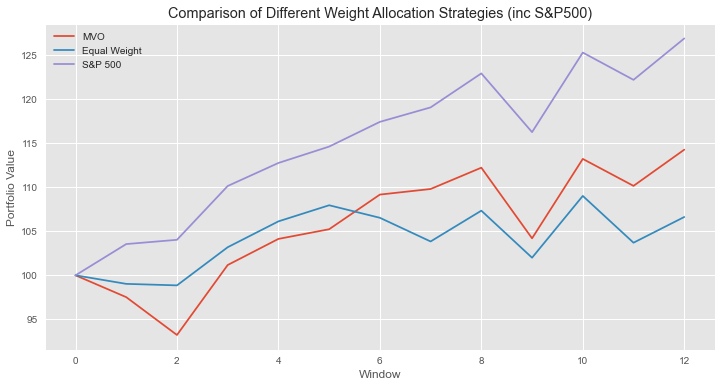

In [269]:
# Plot strategies (MVO, Equal Weights)
plt.figure(figsize=(12,6))
plt.plot(x, curr_total_MVO_portfolio, label="MVO")
plt.plot(x, curr_total_equal_weight_portfolio, label = "Equal Weight")
plt.plot(x, curr_total_s_p_500, label="S&P 500")
plt.xlabel('Window')
plt.ylabel('Portfolio Value')
plt.title('Comparison of Different Weight Allocation Strategies (inc S&P500)')
plt.legend()
plt.show()

As we can see MVO outperforms Equal Weight, which shows that it does allow for a more optimal weight allocation, but the S&P500 benchmark did outperform all. This is because the stock market had a very strong year post-COVID, recording the highest annual % percentage since 2013 (excluding 2019). Part of this was due to fiscal stimulus and the enormous amount of cash being injected into the market (more on this will be discussed in the report).

NameError: name 'curr_total_s_p_500' is not defined